In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numba as nb
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
from scipy.optimize import minimize

from aeons.covariance import logX_mu, logX_covinv_chol, points_at_iteration, logPr, logPr_params
from true_distribution import generate_Xs, generate_Xsamples

# Load test samples
from aeons.tools import pickle_in
samples_g_1, samples_c_1, samples_w_1 = pickle_in("../test_samples/samples_1.pickle")

Try to make a successful prediction using the true mean and covariance of X

Can we use the partial covariance matrix?

In [2]:
def logL_X(X, theta):
    d = theta
    return - X**(2/d)

def X_logL(logL, theta):
    d, = theta
    return np.exp(d/2 * np.log(-logL))

def minimize_theta(logL, mean, cov_inv, x0):
    def func(theta):
        X = X_logL(logL, theta)
        return (X - mean).T @ cov_inv @ (X - mean) # want to maximise probability <-> minimise negative
    solution = minimize(func, x0)
    return solution

- Input: flat live point distribution

Doesn't work well when X is small?

In [36]:
nlive = 500
iterations = 1000
nk = nlive * np.ones(iterations)

- Repeatedly generate X to calculate mean and covariance

In [37]:
X_samples = generate_Xsamples(nk, 2000)

mean_X = np.mean(X_samples, axis=0)
cov_X = np.cov(X_samples.T)
covinv_X = np.linalg.inv(cov_X)

array([11.76037207])

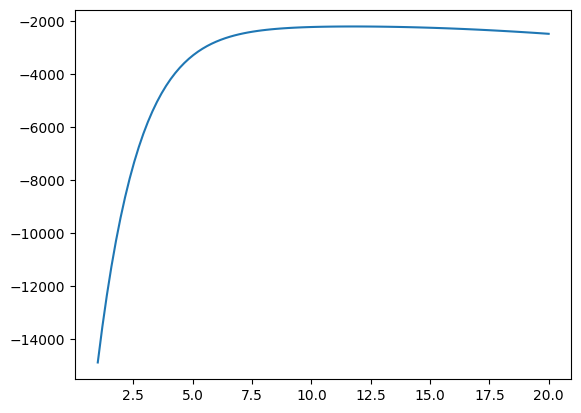

In [44]:
X_sample = generate_Xs(nk)
logL = logL_X(X_sample, 10)

prs = []
ds = np.linspace(1, 20, 100)
for d in ds:
    X = X_logL(logL, [d])
    pr = -(X - mean_X).T @ covinv_X @ (X - mean_X)
    prs.append(pr)
plt.plot(ds, prs)

minimize_theta(logL, mean_X, covinv_X, 10).x

Now generate a single chain of X, calculate L(X) for d = 10, then find d which optimises the probability of L(X) occuring

In [35]:
for i in range(10):
    X_sample = generate_Xs(nk)
    logL = logL_X(X_sample, 10)
    params_cg = minimize_theta(logL, mean_X, covinv_X, 10).x
    print(params_cg)

[540.87057723]
[1638.51650833]
[19.77921229]
[25.83221658]
[10.]
[10.]
[10.78030512]
[122.48941672]
[29.63232411]


/tmp/ipykernel_28755/461065030.py:12: RuntimeWarning: overflow encountered in matmul
  return (X - mean).T @ cov_inv @ (X - mean) # want to maximise probability <-> minimise negative
/tmp/ipykernel_28755/461065030.py:12: RuntimeWarning: invalid value encountered in matmul
  return (X - mean).T @ cov_inv @ (X - mean) # want to maximise probability <-> minimise negative
/tmp/ipykernel_28755/461065030.py:7: RuntimeWarning: overflow encountered in exp
  return np.exp(d/2 * np.log(-logL))


[-1024.24]


/tmp/ipykernel_28755/461065030.py:12: RuntimeWarning: overflow encountered in matmul
  return (X - mean).T @ cov_inv @ (X - mean) # want to maximise probability <-> minimise negative
/tmp/ipykernel_28755/461065030.py:12: RuntimeWarning: invalid value encountered in matmul
  return (X - mean).T @ cov_inv @ (X - mean) # want to maximise probability <-> minimise negative
/tmp/ipykernel_28755/461065030.py:12: RuntimeWarning: overflow encountered in matmul
  return (X - mean).T @ cov_inv @ (X - mean) # want to maximise probability <-> minimise negative
/tmp/ipykernel_28755/461065030.py:12: RuntimeWarning: invalid value encountered in matmul
  return (X - mean).T @ cov_inv @ (X - mean) # want to maximise probability <-> minimise negative


In [114]:
for i in range(10):
    X_sample = generate_Xs(nk)
    logL = logL_X(X_sample, 10)
    params_ls = minimize_theta(logL, mean_X, np.eye(len(mean_X)), 10).x
    print(params_ls)

[9.92859821]
[9.23170372]
[9.88885155]
[9.90538677]
[9.29071853]
[10.41209416]
[10.01877623]
[10.01369378]
[9.65866292]
[9.88362341]


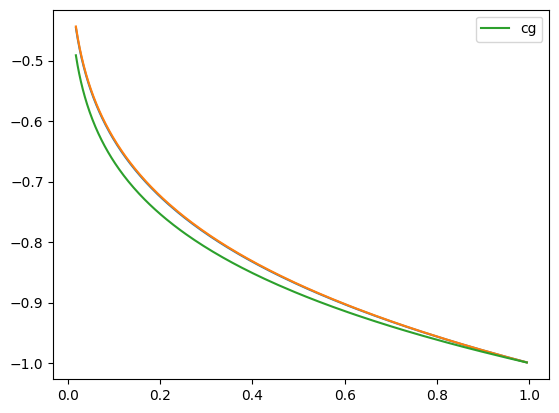

In [71]:
plt.plot(X_sample, logL_X(X_sample, 10))
plt.plot(X_sample, logL_X(X_sample, params_ls))
plt.plot(X_sample, logL_X(X_sample, params_cg), label='cg')
plt.legend()

In [56]:
from aeons.covariance import logX_model, logPr
def optimise_pr_cg(logL, mean, cov_inv, x0):
    def func(theta):
        logX = logX_model(logL, *theta)
        return - logPr(logX, mean, cov_inv) # want to maximise probability <-> minimise negative
    solution = minimize(func, x0, method='Nelder-Mead')
    return solution

In [45]:
from covariance import logPr_params

logPr_test = logPr_params(logL, mean, covinv, [-2, 8.9, 0.1])
print(f"{logPr_test:.2e}")

-3.53e+07


In [57]:
from lm_partial import analytic_lm_params
analytic_lm_params(logL, mean_X, 10)

[-1.6307473394785745, 8.97265352461834, 0.10176917006706997]

In [58]:
params_cg = optimise_pr_cg(logL, mean_X, covinv_X, [-2, 10, 0.1]).x

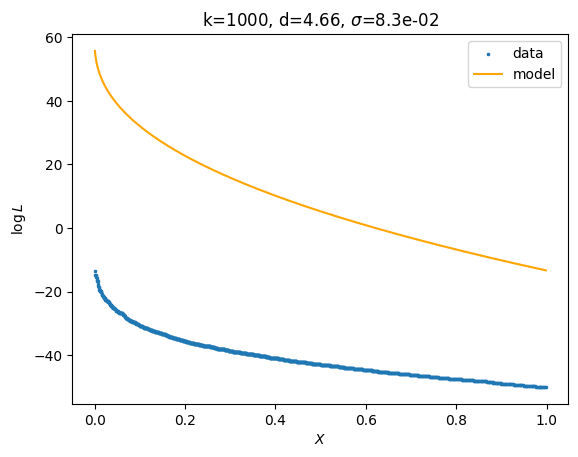

In [59]:
from plotting import plot_fit_raw
plot_fit_raw(mean_X, logL, params_cg)

## Contour plots